In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os  
import tensorflow as tf
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from glob import glob
import plotly.express as px
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import compute_sample_weight, compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
# Making Dictionary of images and labels
skin_dir = os.path.join('.', 'input')
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(skin_dir, '*', '*.jpg'))}
# Create dictionary human-friendly labels 
type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
# Check again input data
os.listdir('.\\input')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv.zip',
 'hmnist_28_28_RGB.csv.zip',
 'hmnist_8_8_L.csv.zip',
 'hmnist_8_8_RGB.csv.zip']

In [5]:
skin_data = pd.read_csv(os.path.join(skin_dir, 'HAM10000_metadata.csv'))
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [6]:
# Creating New Columns 
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(type_dict.get) 
skin_data['cell_id'] = pd.Categorical(skin_data['cell_type']).codes

In [7]:
# Now lets see the sample of data frame to look on newly made columns
skin_data.sample(5)

lesion_id      image_id   dx    dx_type   age     sex  \
1994  HAM_0002622  ISIC_0030187  mel      histo  35.0    male   
2185  HAM_0004164  ISIC_0031203  mel      histo  80.0    male   
3146  HAM_0005867  ISIC_0032387   nv  follow_up  65.0  female   
6574  HAM_0000731  ISIC_0026813   nv  follow_up  40.0  female   
8314  HAM_0002979  ISIC_0030588   nv      histo  35.0  female   

         localization                                             path  \
1994  upper extremity  .\input\HAM10000_images_part_2\ISIC_0030187.jpg   
2185  lower extremity  .\input\HAM10000_images_part_2\ISIC_0031203.jpg   
3146            trunk  .\input\HAM10000_images_part_2\ISIC_0032387.jpg   
6574  upper extremity  .\input\HAM10000_images_part_1\ISIC_0026813.jpg   
8314             back  .\input\HAM10000_images_part_2\ISIC_0030588.jpg   

             cell_type  cell_id  
1994          Melanoma        5  
2185          Melanoma        5  
3146  Melanocytic nevi        4  
6574  Melanocytic nevi        4  
8314  Melanocytic nevi        4

In [8]:
#Data Preprocessing
#Cleaning Data
skin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
path            10015 non-null object
cell_type       10015 non-null object
cell_id         10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB


In [9]:
skin_data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
cell_type        0
cell_id          0
dtype: int64

In [10]:
skin_data = skin_data.dropna(how='any')
skin_data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
cell_type       0
cell_id         0
dtype: int64

In [11]:
print(skin_data.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
path             object
cell_type        object
cell_id            int8
dtype: object


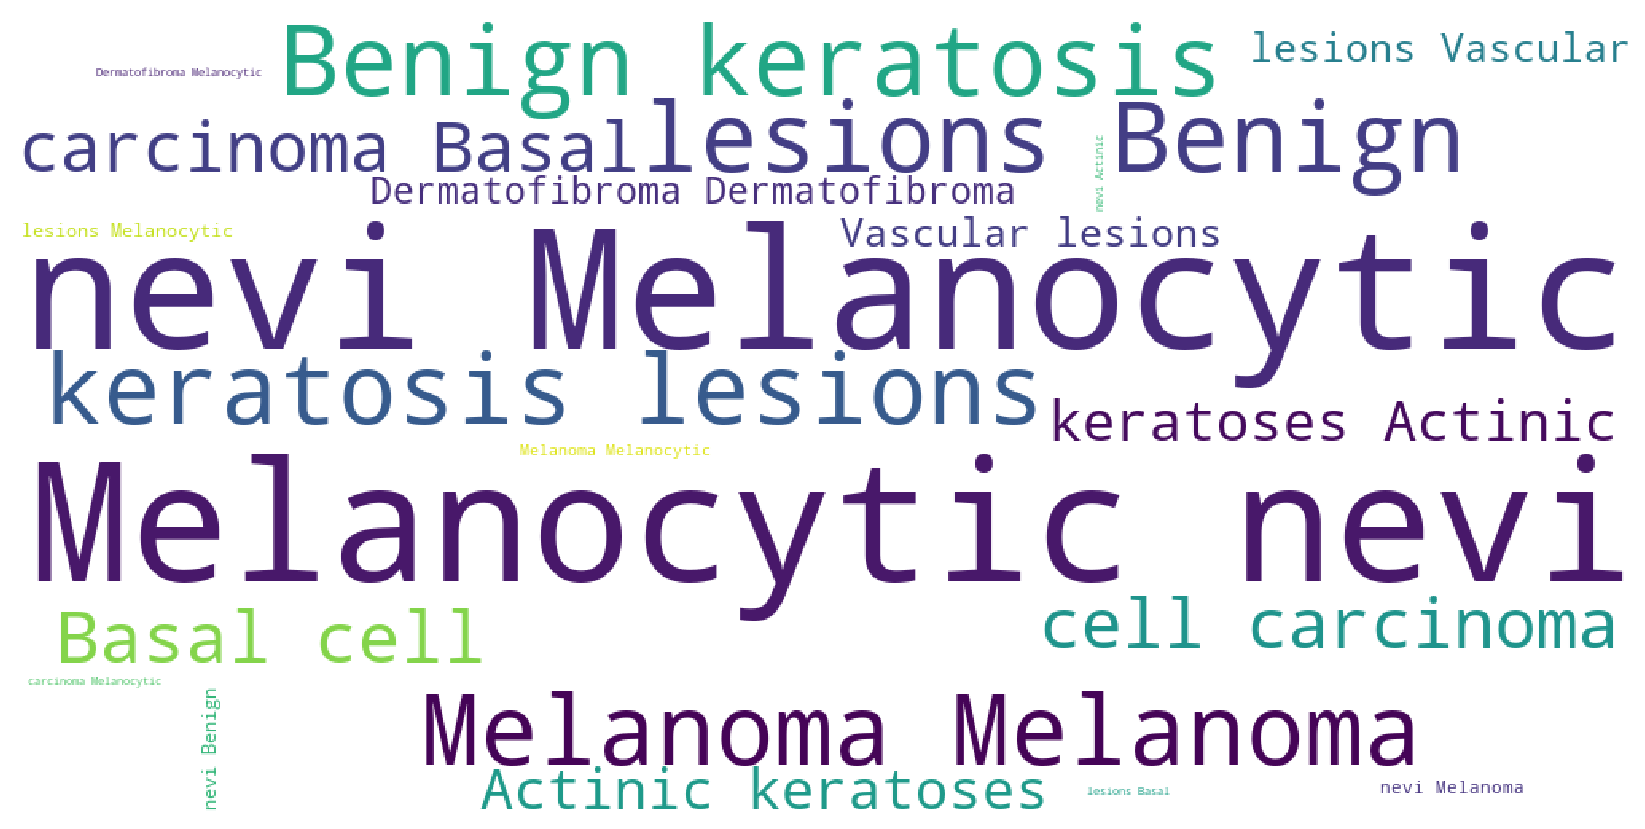

In [12]:
#Data Visualization
data = skin_data.cell_type
plt.subplots(figsize=(30,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1024,
                          height=512
                         ).generate(" ".join(data))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph_cell.png')

plt.show()

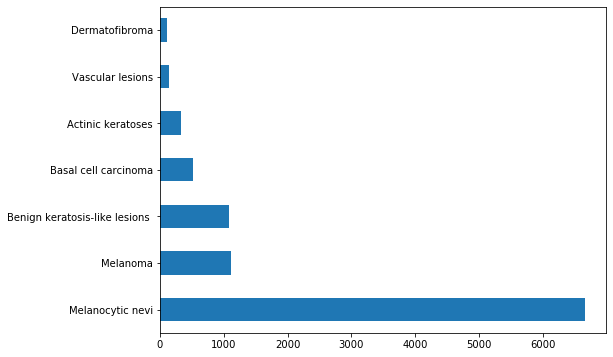

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize= (8, 6))
skin_data['cell_type'].value_counts().plot(kind='barh', ax=ax1)

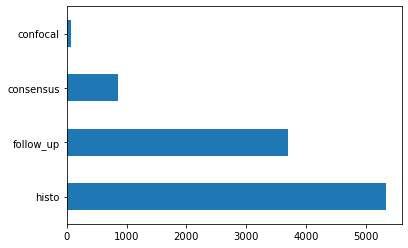

In [14]:
skin_data['dx_type'].value_counts().plot(kind='barh')

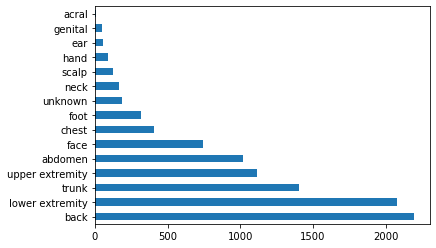

In [15]:
skin_data['localization'].value_counts().plot(kind='barh')

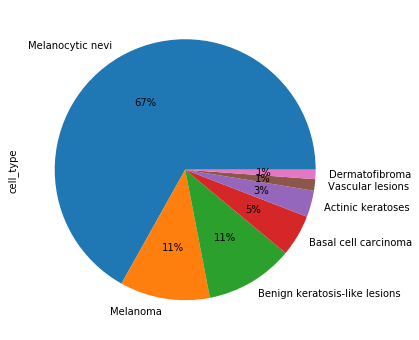

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['cell_type'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

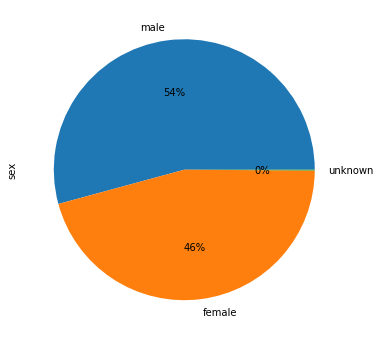

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['sex'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

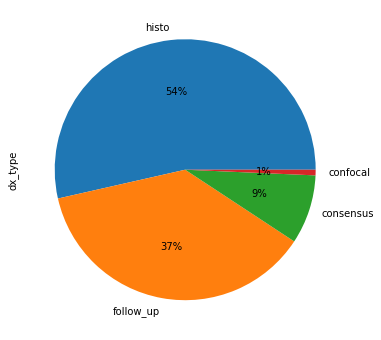

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['dx_type'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

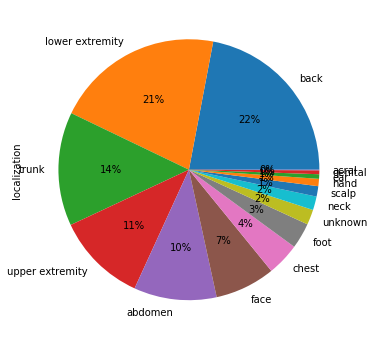

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['localization'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

In [20]:
fig = px.scatter_3d(skin_data, x='localization', y='cell_type', z='sex', color='cell_type')
fig.show()

In [21]:
fig = px.scatter_3d(skin_data, x='localization', y='cell_type', z='age', color='cell_type')
fig.show()

In [22]:
#resize all the images
skin_data['image'] = skin_data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                              path  \
0  .\input\HAM10000_images_part_1\ISIC_0027419.jpg   
1  .\input\HAM10000_images_part_1\ISIC_0025030.jpg   
2  .\input\HAM10000_images_part_1\ISIC_0026769.jpg   
3  .\input\HAM10000_images_part_1\ISIC_0025661.jpg   
4  .\input\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_id  \
0  Benign keratosis-like lesions         2   
1  Benign keratosis-like lesions         2   
2  Benign keratosis-like lesions         2   
3  Benign keratosis-like lesions         2   
4  Benign keratosis-like lesions         2   

                                               image  
0  [[[191, 153, 194], [191, 154, 198], [189, 152,...  
1  [[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...  
2  [[[186, 126, 136], [190, 136, 149], [195, 137,...  
3  [[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...  
4  [[[136, 91, 114], [148, 104, 127], [161, 117, ...

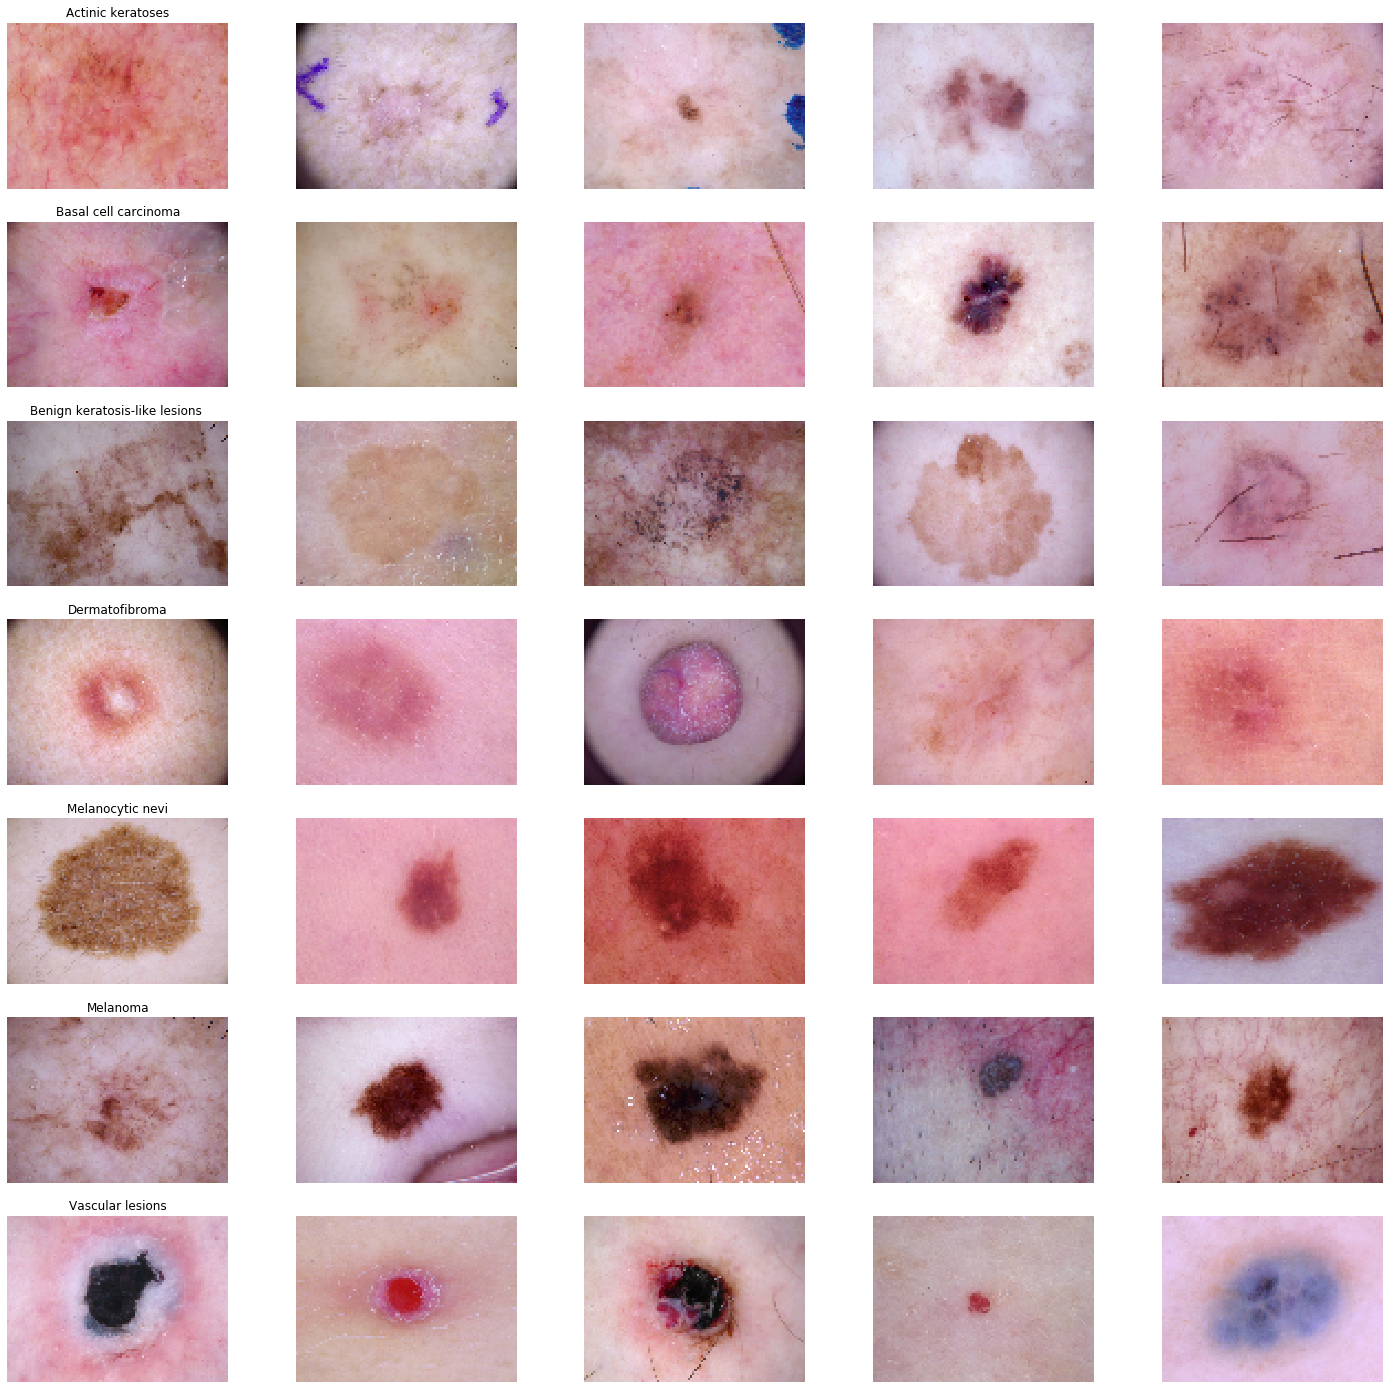

In [23]:
#printing some sample image
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (5*n_samples, 5*5))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=24).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=100)

In [24]:
# Checking the image size distribution
skin_data['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    9958
Name: image, dtype: int64

In [25]:
#Convolutional Neural Network

#Train Test Split 
X_train=skin_data.drop(columns=['cell_id'],axis=1)
Y_train=skin_data['cell_id']
x_o_train, x_o_test, y_o_train, y_o_test = train_test_split(X_train, Y_train, test_size=0.10,random_state=24)
#Label Encoding
#Labels are 7 different classes of cell types from 0 to 6. We need to encode these lables to one hot vectors.
y_train = to_categorical(y_o_train, num_classes = 7)
y_test = to_categorical(y_o_test, num_classes = 7)
#Normalization
x_train = np.asarray(x_o_train['image'].tolist())
x_test = np.asarray(x_o_test['image'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
#Training and Validation Split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [26]:
#Data Augmentation to avoiding the overfitting.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [28]:
# tanh + Adagrad
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'tanh'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='Adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

In [29]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 18s 224ms/step - loss: 1.1744 - accuracy: 0.6434 - val_loss: 1.6002 - val_accuracy: 0.4459
Epoch 2/50
 1/80 [..............................] - ETA: 5s - loss: 1.0350 - accuracy: 0.6400

C:\Users\bobby\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning:

Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr



80/80 [==============================] - 15s 183ms/step - loss: 0.8973 - accuracy: 0.6849 - val_loss: 1.6516 - val_accuracy: 0.3991
Epoch 3/50
80/80 [==============================] - 15s 192ms/step - loss: 0.8532 - accuracy: 0.7007 - val_loss: 2.0722 - val_accuracy: 0.2899
Epoch 4/50
80/80 [==============================] - 14s 179ms/step - loss: 0.8269 - accuracy: 0.6996 - val_loss: 1.5711 - val_accuracy: 0.4247
Epoch 5/50
80/80 [==============================] - 14s 175ms/step - loss: 0.8186 - accuracy: 0.7006 - val_loss: 1.9988 - val_accuracy: 0.3021
Epoch 6/50
80/80 [==============================] - 14s 172ms/step - loss: 0.8100 - accuracy: 0.7065 - val_loss: 1.8482 - val_accuracy: 0.3423
Epoch 7/50
80/80 [==============================] - 14s 175ms/step - loss: 0.7885 - accuracy: 0.7132 - val_loss: 1.8852 - val_accuracy: 0.3356
Epoch 8/50
80/80 [==============================] - 14s 174ms/step - loss: 0.7910 - accuracy: 0.7125 - val_loss: 2.0112 - val_accuracy: 0.3055
Epoch 9/50

In [30]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 463us/sample - loss: 1.5081 - accuracy: 0.4638
Validation: accuracy = 0.463768  ;  loss_v = 1.508125
Test: accuracy = 0.481928  ;  loss = 1.463942


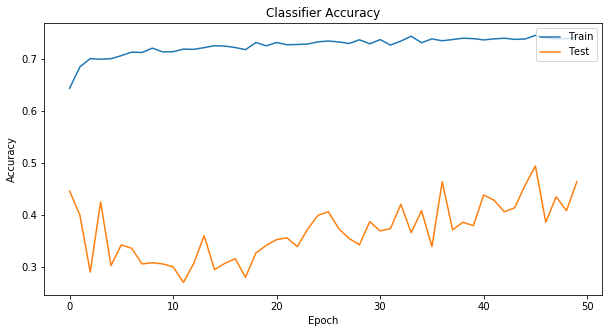

<Figure size 432x288 with 0 Axes>

In [31]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adgard_acc.png")

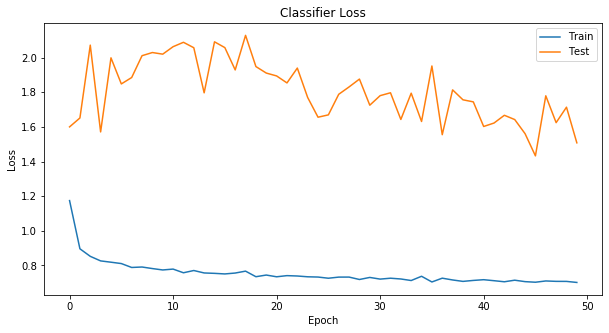

<Figure size 432x288 with 0 Axes>

In [32]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adgard_loss.png")

In [33]:
# tanh + Adam
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'tanh'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 64)       

In [34]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 13s 169ms/step - loss: 2.1503 - accuracy: 0.5854 - val_loss: 1.3025 - val_accuracy: 0.6611
Epoch 2/50
80/80 [==============================] - 13s 156ms/step - loss: 1.4021 - accuracy: 0.6082 - val_loss: 1.4613 - val_accuracy: 0.5764
Epoch 3/50
80/80 [==============================] - 13s 158ms/step - loss: 1.3263 - accuracy: 0.6172 - val_loss: 1.1748 - val_accuracy: 0.6455
Epoch 4/50
80/80 [==============================] - 12s 154ms/step - loss: 1.2689 - accuracy: 0.6329 - val_loss: 1.2067 - val_accuracy: 0.6210
Epoch 5/50
80/80 [==============================] - 12s 154ms/step - loss: 1.2181 - accuracy: 0.6347 - val_loss: 1.0742 - val_accuracy: 0.6544
Epoch 6/50
80/80 [==============================] - 12s 155ms/step - loss: 1.1602 - accuracy: 0.6404 - val_loss: 1.1186 - val_accuracy: 0.6254
Epoch 7/50
80/80 [==============================] - 12s 155ms/step - loss: 1.0926 - accuracy: 0.6457 - val_loss: 1.0298 - val_accuracy: 0.6600

In [35]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 533us/sample - loss: 0.8414 - accuracy: 0.6912
Validation: accuracy = 0.691193  ;  loss_v = 0.841447
Test: accuracy = 0.692771  ;  loss = 0.820134


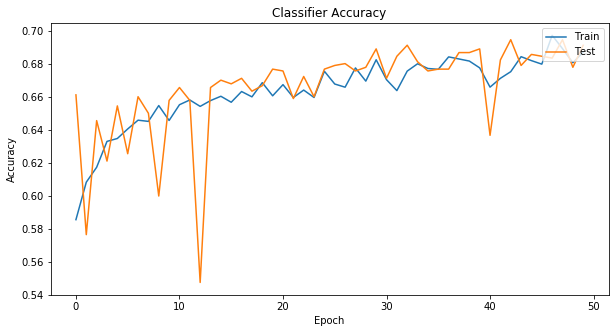

<Figure size 432x288 with 0 Axes>

In [36]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adam_acc.png")


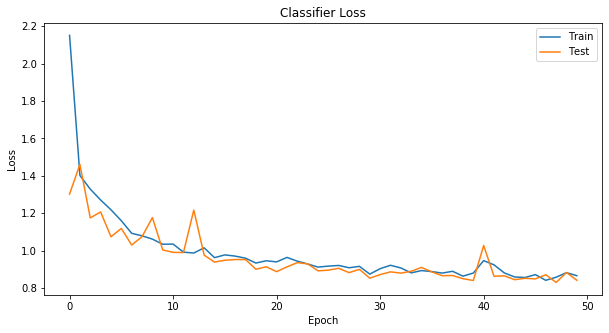

<Figure size 432x288 with 0 Axes>

In [37]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adam_loss.png")


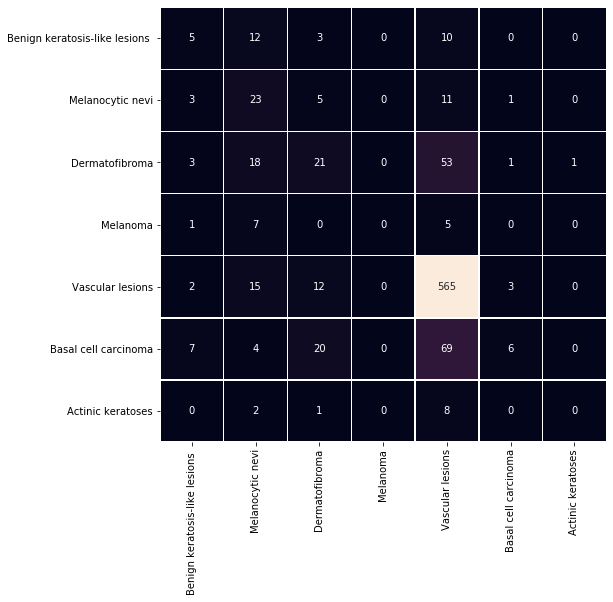

In [38]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_tanh_adam.png")
plt.show()

In [39]:
# tanh + RMSprop
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'tanh'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 25, 64)       

In [40]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 20s 244ms/step - loss: 1.9753 - accuracy: 0.6088 - val_loss: 1.4375 - val_accuracy: 0.5474
Epoch 2/50
80/80 [==============================] - 19s 234ms/step - loss: 1.3840 - accuracy: 0.6175 - val_loss: 1.5504 - val_accuracy: 0.5284
Epoch 3/50
80/80 [==============================] - 18s 221ms/step - loss: 1.2940 - accuracy: 0.6265 - val_loss: 1.1660 - val_accuracy: 0.6656
Epoch 4/50
80/80 [==============================] - 17s 207ms/step - loss: 1.2778 - accuracy: 0.6516 - val_loss: 1.1510 - val_accuracy: 0.6656
Epoch 5/50
80/80 [==============================] - 17s 208ms/step - loss: 1.2340 - accuracy: 0.6639 - val_loss: 1.1491 - val_accuracy: 0.6656
Epoch 6/50
80/80 [==============================] - 18s 228ms/step - loss: 1.2090 - accuracy: 0.6643 - val_loss: 1.1576 - val_accuracy: 0.6656
Epoch 7/50
80/80 [==============================] - 21s 261ms/step - loss: 1.1820 - accuracy: 0.6653 - val_loss: 1.1184 - val_accuracy: 0.6656

In [41]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 1s 565us/sample - loss: 0.8913 - accuracy: 0.6756
Validation: accuracy = 0.675585  ;  loss_v = 0.891303
Test: accuracy = 0.672691  ;  loss = 0.878650


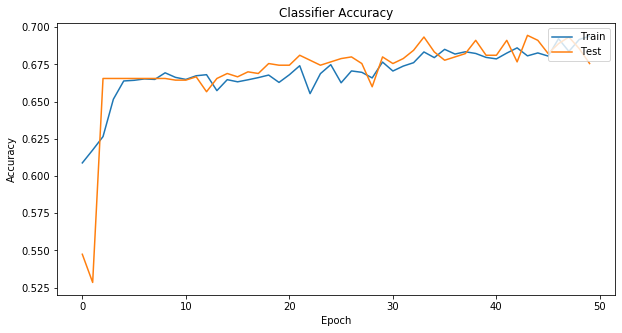

<Figure size 432x288 with 0 Axes>

In [42]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+RMsporp_acc.png")

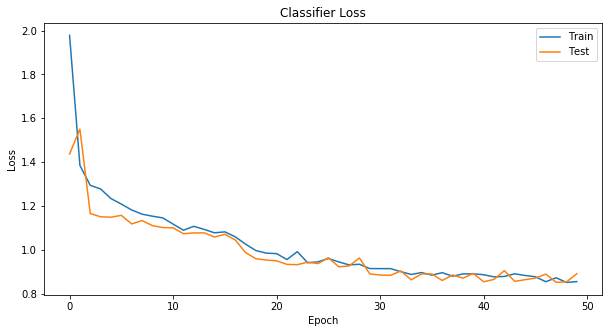

<Figure size 432x288 with 0 Axes>

In [43]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+RMsporp_loss.png")


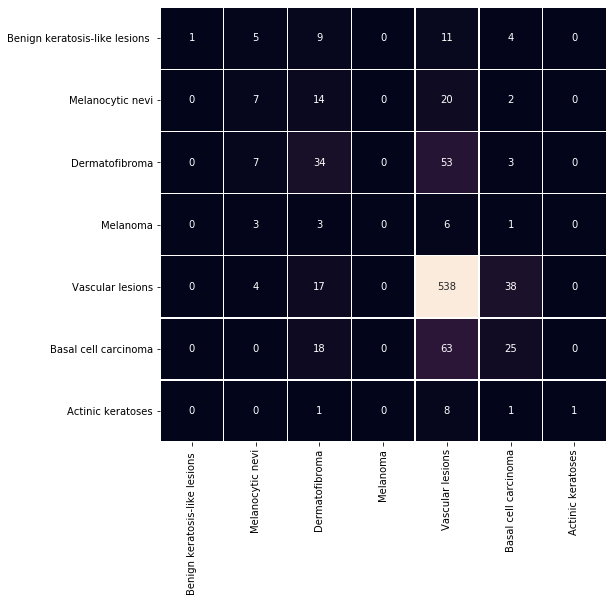

In [44]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_tanh_rmsprop.png")
plt.show()

In [45]:
# relu+Adagrad
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'relu'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='Adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 25, 64)       

In [46]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 21s 257ms/step - loss: 1.0772 - accuracy: 0.6599 - val_loss: 1.1650 - val_accuracy: 0.6611
Epoch 2/50
80/80 [==============================] - 20s 245ms/step - loss: 0.9786 - accuracy: 0.6680 - val_loss: 1.1459 - val_accuracy: 0.6700
Epoch 3/50
80/80 [==============================] - 19s 236ms/step - loss: 0.9373 - accuracy: 0.6692 - val_loss: 1.1579 - val_accuracy: 0.6600
Epoch 4/50
80/80 [==============================] - 20s 247ms/step - loss: 0.9174 - accuracy: 0.6703 - val_loss: 1.0668 - val_accuracy: 0.6633
Epoch 5/50
80/80 [==============================] - 19s 236ms/step - loss: 0.8935 - accuracy: 0.6717 - val_loss: 1.0073 - val_accuracy: 0.6823
Epoch 6/50
80/80 [==============================] - 19s 242ms/step - loss: 0.8839 - accuracy: 0.6721 - val_loss: 1.0860 - val_accuracy: 0.6789
Epoch 7/50
80/80 [==============================] - 19s 234ms/step - loss: 0.8667 - accuracy: 0.6825 - val_loss: 1.0532 - val_accuracy: 0.6656

In [47]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 1s 591us/sample - loss: 0.9101 - accuracy: 0.6611
Validation: accuracy = 0.661093  ;  loss_v = 0.910122
Test: accuracy = 0.677711  ;  loss = 0.902647


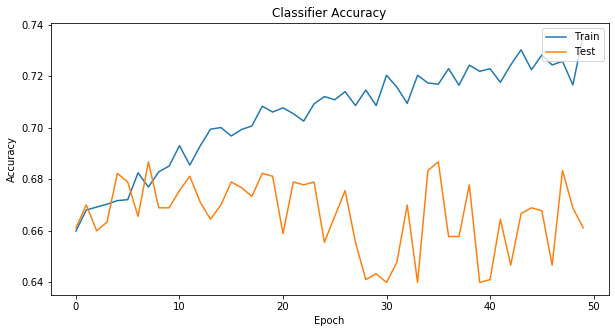

<Figure size 432x288 with 0 Axes>

In [48]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adagrad_acc.png")

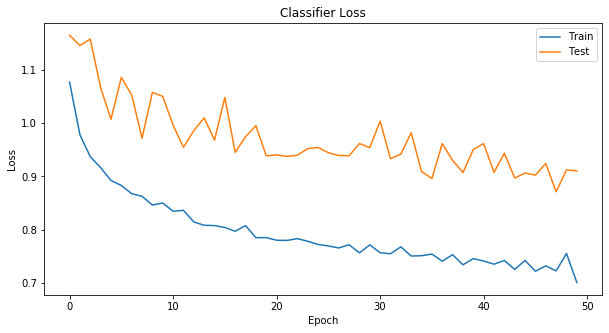

<Figure size 432x288 with 0 Axes>

In [49]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adagrad_loss.png")


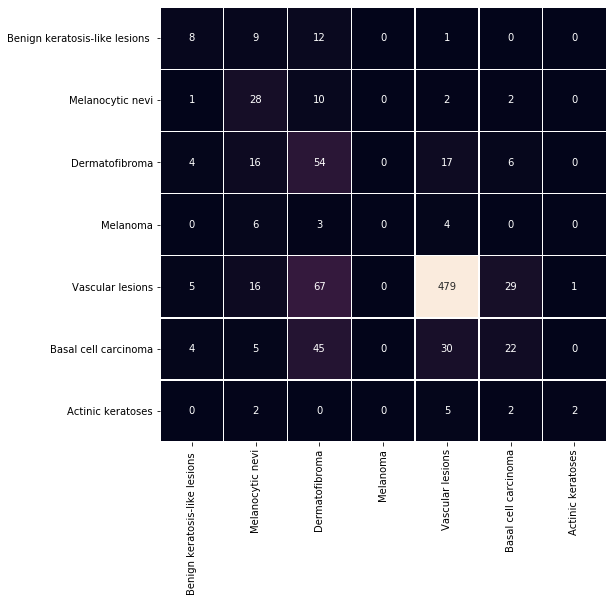

In [50]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_relu_adagrad.png")
plt.show()

In [51]:
# relu+Adam
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'relu'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 25, 64)       

In [52]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 22s 271ms/step - loss: 1.0302 - accuracy: 0.6580 - val_loss: 0.9851 - val_accuracy: 0.6656
Epoch 2/50
80/80 [==============================] - 20s 244ms/step - loss: 0.9134 - accuracy: 0.6693 - val_loss: 0.8951 - val_accuracy: 0.6689
Epoch 3/50
80/80 [==============================] - 19s 238ms/step - loss: 0.8667 - accuracy: 0.6801 - val_loss: 0.9007 - val_accuracy: 0.6767
Epoch 4/50
80/80 [==============================] - 20s 247ms/step - loss: 0.8445 - accuracy: 0.6883 - val_loss: 0.9255 - val_accuracy: 0.6778
Epoch 5/50
80/80 [==============================] - 19s 241ms/step - loss: 0.8260 - accuracy: 0.6901 - val_loss: 0.8788 - val_accuracy: 0.7146
Epoch 6/50
80/80 [==============================] - 19s 241ms/step - loss: 0.7919 - accuracy: 0.7066 - val_loss: 0.7910 - val_accuracy: 0.7258
Epoch 7/50
80/80 [==============================] - 19s 240ms/step - loss: 0.7671 - accuracy: 0.7153 - val_loss: 0.8235 - val_accuracy: 0.7012

In [53]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 461us/sample - loss: 0.6455 - accuracy: 0.7547
Validation: accuracy = 0.754738  ;  loss_v = 0.645533
Test: accuracy = 0.772088  ;  loss = 0.651739


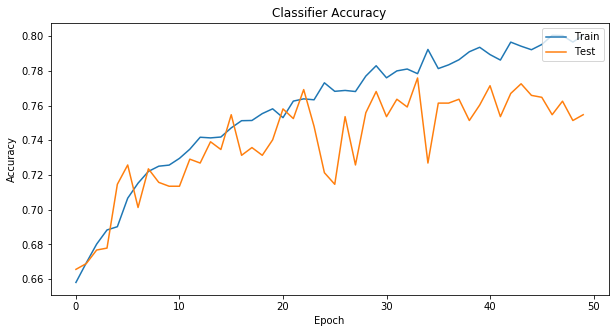

<Figure size 432x288 with 0 Axes>

In [54]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adam_acc.png")

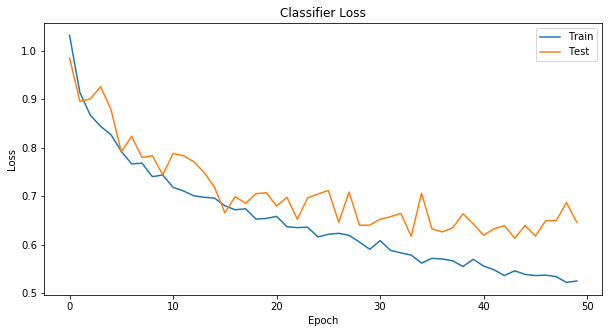

<Figure size 432x288 with 0 Axes>

In [55]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adam_loss.png")


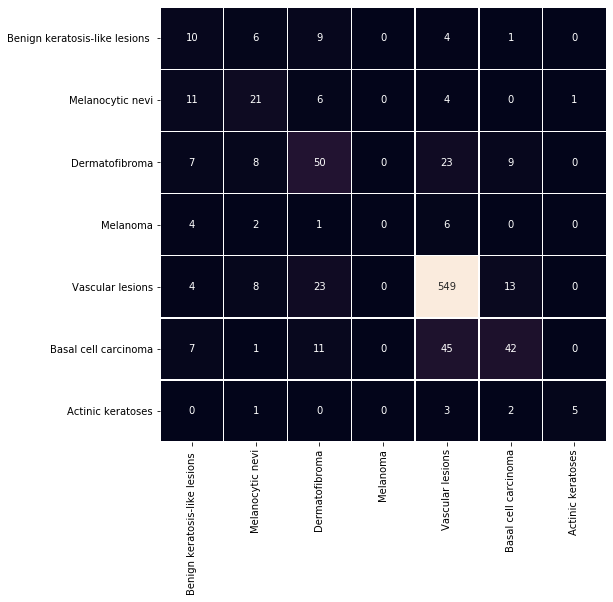

In [56]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_relu_adam.png")
plt.show()

In [57]:
# relu+RMsprop
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'relu'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='RMsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 25, 64)       

In [58]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 15s 184ms/step - loss: 1.4502 - accuracy: 0.6454 - val_loss: 0.9982 - val_accuracy: 0.6689
Epoch 2/50
80/80 [==============================] - 14s 172ms/step - loss: 0.9735 - accuracy: 0.6674 - val_loss: 0.9157 - val_accuracy: 0.6722
Epoch 3/50
80/80 [==============================] - 14s 170ms/step - loss: 0.9192 - accuracy: 0.6731 - val_loss: 0.8355 - val_accuracy: 0.6778
Epoch 4/50
80/80 [==============================] - 13s 169ms/step - loss: 0.8639 - accuracy: 0.6904 - val_loss: 0.9457 - val_accuracy: 0.6957
Epoch 5/50
80/80 [==============================] - 14s 173ms/step - loss: 0.8414 - accuracy: 0.7030 - val_loss: 0.8123 - val_accuracy: 0.7046
Epoch 6/50
80/80 [==============================] - 14s 170ms/step - loss: 0.8045 - accuracy: 0.7091 - val_loss: 0.8453 - val_accuracy: 0.7202
Epoch 7/50
80/80 [==============================] - 14s 179ms/step - loss: 0.7920 - accuracy: 0.7135 - val_loss: 0.9183 - val_accuracy: 0.7057

In [59]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 441us/sample - loss: 0.7661 - accuracy: 0.7358
Validation: accuracy = 0.735786  ;  loss_v = 0.766088
Test: accuracy = 0.768072  ;  loss = 0.732625


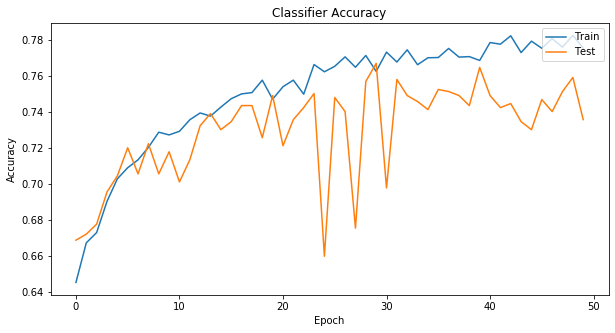

<Figure size 432x288 with 0 Axes>

In [60]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+RMsporp_acc.png")

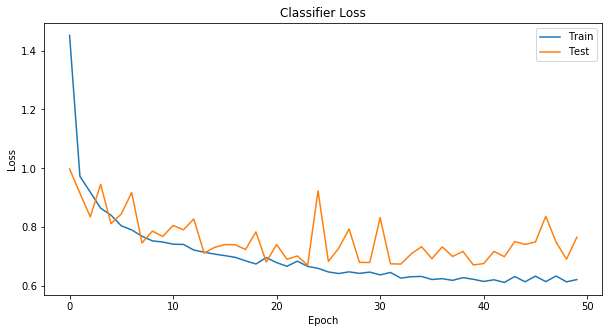

<Figure size 432x288 with 0 Axes>

In [61]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+RMsprop_loss.png")


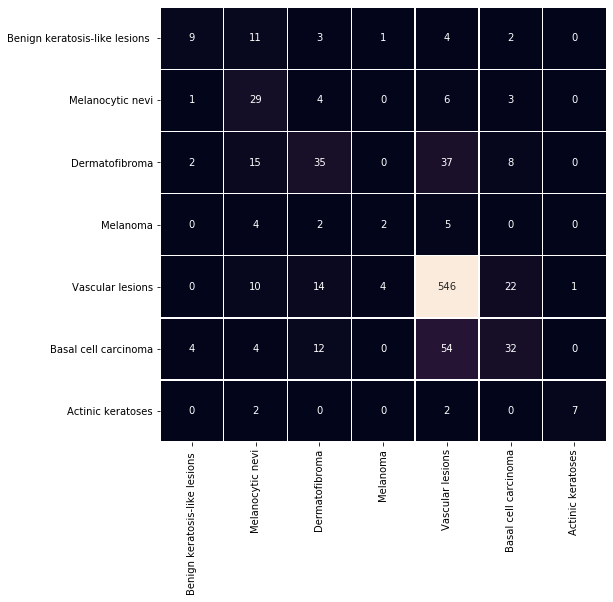

In [62]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_relu_rmsprop.png")
plt.show()